In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir("../")

In [58]:
import torch

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic

import neural_lam.constants as constants

import glob

# Investigate MEPS sample

In [3]:
# samples_dir = glob.glob("./data/meps_example/samples/train/nwp_2*")
samples_dir = glob.glob("./data/new_era5_uk/samples/train/*")
sample = np.load(samples_dir[0])

In [4]:
print(sample.shape)

(3705, 48)


# Investigate MEPS Graph

In [109]:
# dataset = "meps_example"
# graph = "multiscale"

# dataset = "new_era5_uk"
# graph = "test_uk_grid"

dataset = "new_era5_uk_big"
graph = "uk_big_grid"

static_dir_path = os.path.join("data", dataset, "static")
dir = os.path.join(static_dir_path, "nwp_xy.npy")
graph_dir_path = os.path.join("graphs", graph)

In [110]:
xy = np.load(dir)
print(xy.shape)

grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))
print(pos_max)

x, y = xy
extent = [x.min(), x.max(), y.min(), y.max()]
extent

(2, 81, 81)
tensor(65.)


[-13.0, 7.0, 45.0, 65.0]

In [111]:
constants.MEPSConstants.GRID_LIMITS

[-1059506.5523409774,
 1310493.4476590226,
 -1331732.4471934352,
 1338267.5528065648]

In [117]:

# proj = constants.LAMBERT_PROJ
proj = ccrs.PlateCarree()
RADIUS = 0.67 * 0.7407407407407407

def add_geo_features(ax):
    ax.add_feature(cfeature.BORDERS, linestyle=':')
       
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
def add_cities(ax, cities):
    for city, (lon, lat) in cities.items():
        ax.plot(lon, lat, 'ro', transform=proj)
        ax.text(lon + 0.1, lat + 0.1, city, transform=proj)
        
def bounding_box(ax, box):
    lon_min, lon_max, lat_min, lat_max = box
    top_left = [lon_min, lat_max]
    top_right = [lon_max, lat_max]
    bottom_left = [lon_min, lat_min]
    bottom_right = [lon_max, lat_min]
    
    corners = [
        bottom_left,
        top_left,
        top_right,
        bottom_right,
        bottom_left,
    ]
    
    lons, lats = zip(*corners)
    
    ax.plot(
        lons, lats,
        "r-", 
        transform=proj
    )
    

def grid_points(ax, grid_xy):
    ax.plot(grid_xy[0], grid_xy[1], 'ro', transform=proj, markersize=1)

def mesh_points(ax, mesh_pos, style="go", markersize=3, radius=None):
    ax.plot(mesh_pos[0], mesh_pos[1], style, transform=proj, markersize=markersize)
    # if radius:
    #     for lon, lat in mesh_pos.T[:4]:
    #         geod = Geodesic()
    #         circle_points = geod.circle(lon, lat, radius=500000, n_samples=30)
    #         print(lon, lat)
    #         print(circle_points.shape)
    #         print(circle_points)
    #         # ax.plot(circle_points[:, 0], circle_points[:, 1], color="green", transform=proj)

def m2m_edges(ax, mesh_pos, m2m_edge_set):        
    for edge in m2m_edge_set:
        source = mesh_pos[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "g-", 
            transform=proj,
            linewidth=0.5
        )
        
def g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set):
    for edge in g2m_edge_set:
        # if edge[0] % 100 != 0:
        #     continue
        source = grid_xy[:, edge[0]]
        target = mesh_pos[:, edge[1]]
        # ax.plot(source[0], source[1], "ro", markersize=1, transform=proj)
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "b-", 
            transform=proj,
            linewidth=0.5
        )

def m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set):        
    for edge in m2g_edge_set:
        if edge[1] % 100 != 0:
            continue
        source = mesh_pos[:, edge[0]]
        target = grid_xy[:, edge[1]]
        ax.plot(
            [source[0], target[0]],
            [source[1], target[1]], 
            "r-", 
            transform=proj,
            linewidth=0.5
        )
        
def degrees(edge_index):
    degrees = [0] * (max(edge_index[0]) + 1)
    for i in range(edge_index.shape[1]):
        degrees[edge_index[0, i]] += 1
        
    return max(degrees), min(degrees)

def grid_extent(grid_xy):
    x, y = grid_xy
    return [x.min(), x.max(), y.min(), y.max()]

def relabel_node_idxs(edge_index):
    return edge_index - edge_index.min(dim=1, keepdim=True)[0]

## Load graph data

In [148]:
# Load grid
grid_xy = np.load(dir)
print(grid_xy.shape)
grid_xy = grid_xy.reshape(2, -1)

# Load mesh nodes
# mesh_pos = np.load(os.path.join(graph_dir_path, "mesh_pos.npy"))
level = 0

mesh_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt"))[level].T # (2, n_mesh)
mesh_pos = mesh_pos[[0, 1]]
m2m_edge_index = torch.load(os.path.join(graph_dir_path, "m2m_edge_index.pt"))[level]
edge_set = {tuple(sorted(e)) for e in m2m_edge_index.T}

# mesh1_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt"))[level + 1].T # (2, n_mesh)
# mesh1_pos = mesh1_pos[[0, 1]]
# mesh2_pos = torch.load(os.path.join(graph_dir_path, "mesh_pos.pt"))[level + 2].T # (2, n_mesh)
# mesh2_pos = mesh2_pos[[0, 1]]

g2m_edge_index = torch.load(os.path.join(graph_dir_path, "g2m_edge_index.pt"))
# g2m_edge_index = relabel_node_idxs(g2m_edge_index)
grids, nodes = g2m_edge_index
grids = grids - mesh_pos.shape[1]
g2m_edge_index = torch.stack([grids, nodes])
g2m_edge_set = sorted(list({tuple(e) for e in g2m_edge_index.T}))

m2g_edge_index = torch.load(os.path.join(graph_dir_path, "m2g_edge_index.pt"))
# m2g_edge_index = relabel_node_idxs(m2g_edge_index)
nodes, grids = m2g_edge_index
grids = grids - mesh_pos.shape[1]
m2g_edge_index = torch.stack([nodes, grids])
m2g_edge_set = sorted(list({tuple(e) for e in m2g_edge_index.T}))

(2, 81, 81)


In [149]:
print(grid_xy.shape)
print(mesh_pos.shape)
print(g2m_edge_index.shape)
print(m2m_edge_index.shape)
print(m2g_edge_index.shape)

(2, 6561)
torch.Size([2, 729])
torch.Size([2, 9009])
torch.Size([2, 6096])
torch.Size([2, 26244])


In [152]:
print("Verify g2m connectivity")
print("Grid Nodes min, max: ", g2m_edge_index[0].min(), g2m_edge_index[0].max())
print("Mesh nodes min, max: ", g2m_edge_index[1].min(), g2m_edge_index[1].max())
print("Grid Nodes unique:", g2m_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", g2m_edge_index[1].unique().shape[0])
print("Verify m2g connectivity")
print("Grid Nodes min, max: ", m2g_edge_index[0].min(), m2g_edge_index[0].max())
print("Mesh nodes min, max: ", m2g_edge_index[1].min(), m2g_edge_index[1].max())
print("Grid Nodes unique:", m2g_edge_index[0].unique().shape[0])
print("Mesh nodes unique:", m2g_edge_index[1].unique().shape[0])

Verify g2m connectivity
Grid Nodes min, max:  tensor(1) tensor(6559)
Mesh nodes min, max:  tensor(0) tensor(728)
Grid Nodes unique: 6501
Mesh nodes unique: 729
Verify m2g connectivity
Grid Nodes min, max:  tensor(0) tensor(728)
Mesh nodes min, max:  tensor(0) tensor(6560)
Grid Nodes unique: 729
Mesh nodes unique: 6561


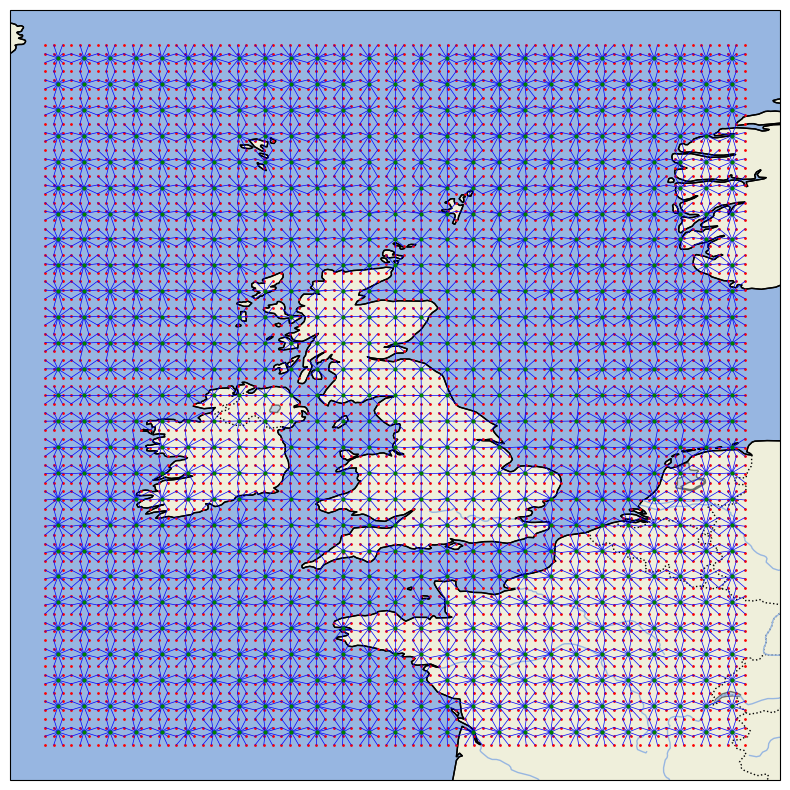

In [154]:
fig, ax = plt.subplots(
    figsize=(10, 10), subplot_kw={"projection": proj}
)

add_geo_features(ax)

grid_points(ax, grid_xy)

g2m_edges(ax, grid_xy, mesh_pos, g2m_edge_set)
# m2g_edges(ax, grid_xy, mesh_pos, m2g_edge_set)
# m2m_edges(ax, mesh_pos, edge_set)
mesh_points(ax, mesh_pos, markersize=2)
# mesh_points(ax, mesh_pos, markersize=2, radius=RADIUS)

# mesh_points(ax, mesh1_pos, style="bo", markersize=3)

# mesh_points(ax, mesh2_pos, style="yo", markersize=4)

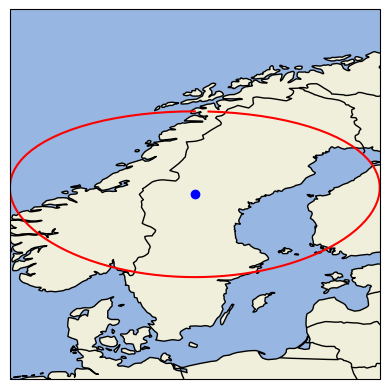

In [64]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

# Center point and radius
center_lon = 15.0  # Longitude of the center point
center_lat = 63.3  # Latitude of the center point
radius = 500000  # Radius in meters

# Function to create circle points
def create_circle(lon, lat, radius, num_points=100):
    geod = Geodesic()
    circle_points = geod.circle(lon=lon, lat=lat, radius=radius, n_samples=num_points)
    return circle_points

circle_points = create_circle(center_lon, center_lat, radius)

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([center_lon - 10, center_lon + 10, center_lat - 10, center_lat + 10], crs=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the circle
ax.plot(circle_points[:, 0], circle_points[:, 1], transform=ccrs.PlateCarree(), color='red')

# Plot the center point
ax.plot(center_lon, center_lat, marker='o', color='blue', transform=ccrs.PlateCarree())

plt.show()
